# Fastai Experimentation

This notebook is intended to be used after running the google image scraper in this repo. To get started follow the README.md in this repo, then come back after all the csv files have been generated, labeled, and saved in the data_csv directory.

In [2]:
from fastai.vision import *
import os
path = Path(f'../data_csv')

### Define Experiment
Running this cell will save the images and any saved models in a directory with the experiments name.

In [3]:
experiment = 'trees_and_leaves'

In [4]:
dest_path = Path(f'../data')
img_path = dest_path/experiment

## Download images per class
The google scraper will save the csv files labeled by the classes you want to train. These csv files will be nested in a directory with the labeled classname. For example:
```
data_csv/
    ash_tree/
        ash_tree.csv
    bigleaf_maple/
        bigleaf_maple.csv
        ...
```
The images will be saved in a data directory nested under experiment name and class name:
```
data/
    trees/
        ash_tree/
            *.jpeg
```

In [9]:
for folder in os.listdir('../data_csv'):
    file = path/folder/os.listdir(f'../data_csv/{folder}')[0]
    dest = img_path/folder
    dest.mkdir(parents=True, exist_ok=True)
    print(folder, '   ',file, ' dest', dest)
    try:
        download_images(file, dest, max_pics=200)
    except Exception as e:
        print(e,' failed to download image for: ', folder)
        pass

## Verify Images can be Trained

In [10]:
classes = os.listdir(f'../data/{experiment}')
for c in classes:
    print(c)
    verify_images(img_path/c, delete=True, max_size=500)

## Create ImageDataBunch for Training

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(img_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

## Show Classes to be Trained

In [6]:
data.classes

['Douglas-fir',
 'Oregon_white_oak',
 'Pacific_madrone',
 'Pacific_willow',
 'Pacific_yew',
 'Ponderosa_pine',
 'Scouler_willow',
 'Western_flowering_dogwood',
 'Western_hemlock',
 'Western_red_cedar',
 'ash_tree',
 'bigleaf_maple',
 'bitter_cherry',
 'black_cottonwood',
 'black_hawthorn',
 'cascara',
 'grand_fir',
 'quaking_aspen',
 'red_alder',
 'rigid_willow']

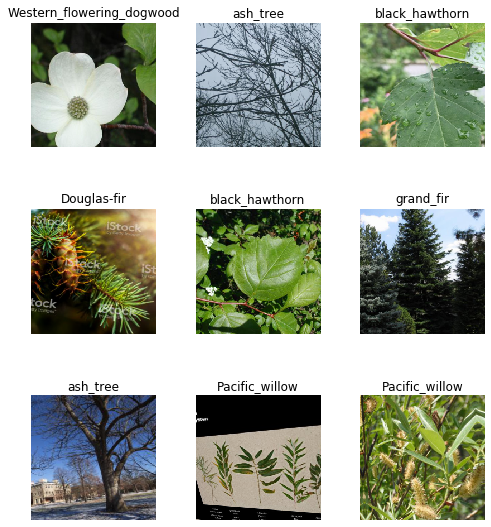

In [13]:
data.show_batch(rows=3, figsize=(7,8))

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Douglas-fir',
  'Oregon_white_oak',
  'Pacific_madrone',
  'Pacific_willow',
  'Pacific_yew',
  'Ponderosa_pine',
  'Scouler_willow',
  'Western_flowering_dogwood',
  'Western_hemlock',
  'Western_red_cedar',
  'ash_tree',
  'bigleaf_maple',
  'bitter_cherry',
  'black_cottonwood',
  'black_hawthorn',
  'cascara',
  'grand_fir',
  'quaking_aspen',
  'red_alder',
  'rigid_willow'],
 20,
 2924,
 730)

In [10]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy], callback_fns=[
    partial(callbacks.EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=5)])

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


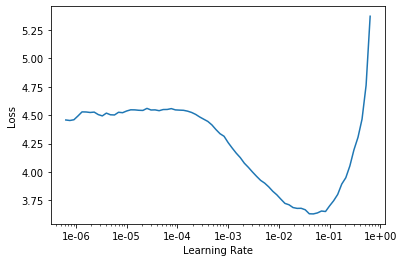

In [17]:
learn.recorder.plot()

In [18]:
learn.save('stage-0')

In [52]:
learn.load('stage-0')

Learner(data=ImageDataBunch;

Train: LabelList (2924 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bigleaf_maple,bigleaf_maple,bigleaf_maple,bigleaf_maple,bigleaf_maple
Path: ../data/trees_and_leaves;

Valid: LabelList (730 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Scouler_willow,bitter_cherry,black_hawthorn,Pacific_yew,Pacific_willow
Path: ../data/trees_and_leaves;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1),

In [53]:
lr=1e-2

In [54]:
learn.fit_one_cycle(4, max_lr=slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.874804,2.011373,0.526027,0.473973,06:14
1,2.207996,1.664221,0.465753,0.534247,06:19
2,1.733687,1.395398,0.428767,0.571233,06:18
3,1.356656,1.331386,0.416438,0.583562,06:19


In [55]:
interp = ClassificationInterpretation.from_learner(learn)

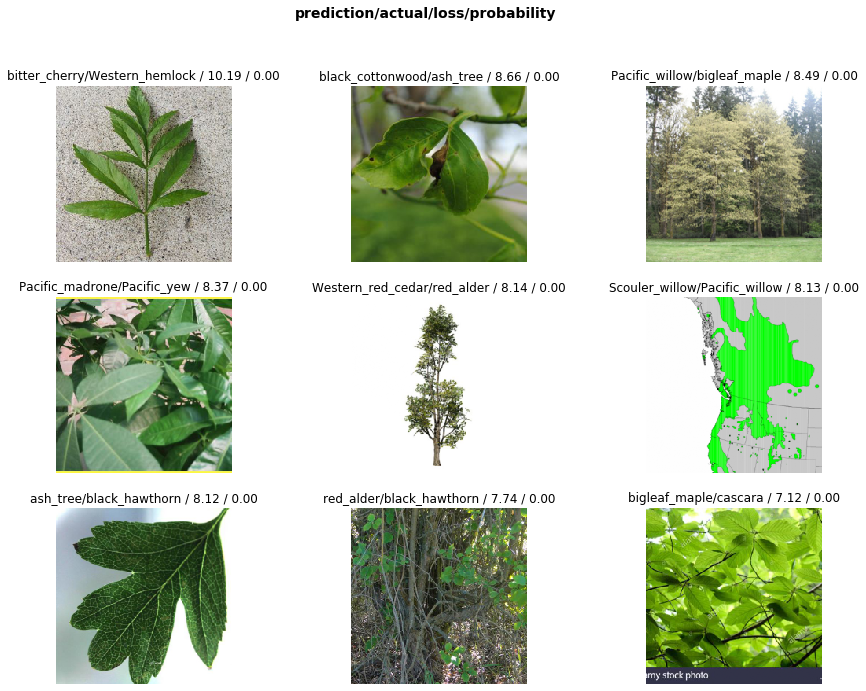

In [56]:
interp.plot_top_losses(9, figsize=(15,11))

## Save Model and Unfreeze Layers

In [57]:
learn.save('stage-1')

In [58]:
learn.unfreeze()

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


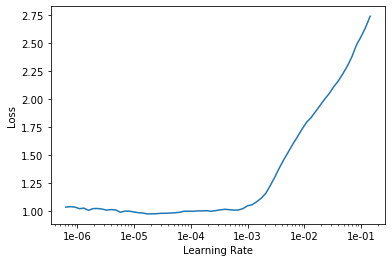

In [60]:
learn.recorder.plot()

In [61]:
starting_lr = 3e-4

## Train All Layers

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.034952,1.251546,0.386301,0.613699,07:53
1,0.876985,1.179425,0.346575,0.653425,07:57
2,0.743882,1.136115,0.332877,0.667123,07:57
3,0.634099,1.098743,0.308219,0.691781,07:58
4,0.530826,1.104462,0.313699,0.686301,07:58
5,0.445507,1.144386,0.323288,0.676712,07:57
6,0.373907,1.145756,0.295890,0.704110,07:58
7,0.323698,1.151264,0.297260,0.702740,07:58
8,0.305775,1.275586,0.317808,0.682192,07:58
9,0.288257,1.273867,0.324658,0.675342,07:57


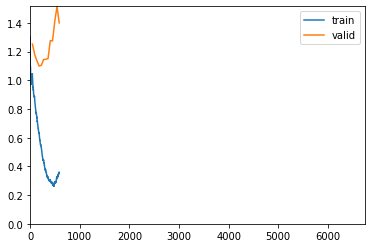

Better model found at epoch 0 with error_rate value: 0.3863013684749603.
Better model found at epoch 1 with error_rate value: 0.3465753495693207.
Better model found at epoch 2 with error_rate value: 0.33287671208381653.
Better model found at epoch 3 with error_rate value: 0.30821916460990906.
Better model found at epoch 6 with error_rate value: 0.2958904206752777.
Epoch 12: early stopping


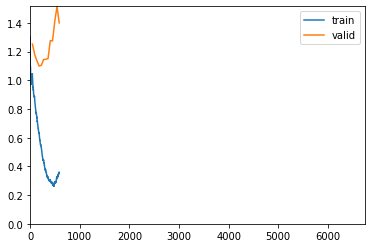

In [63]:
learn.fit_one_cycle(150, max_lr=slice(starting_lr,lr/5),callbacks=[ShowGraph(learn),callbacks.SaveModelCallback(learn,
monitor='error_rate',
mode='min')])

In [64]:
interp = ClassificationInterpretation.from_learner(learn)

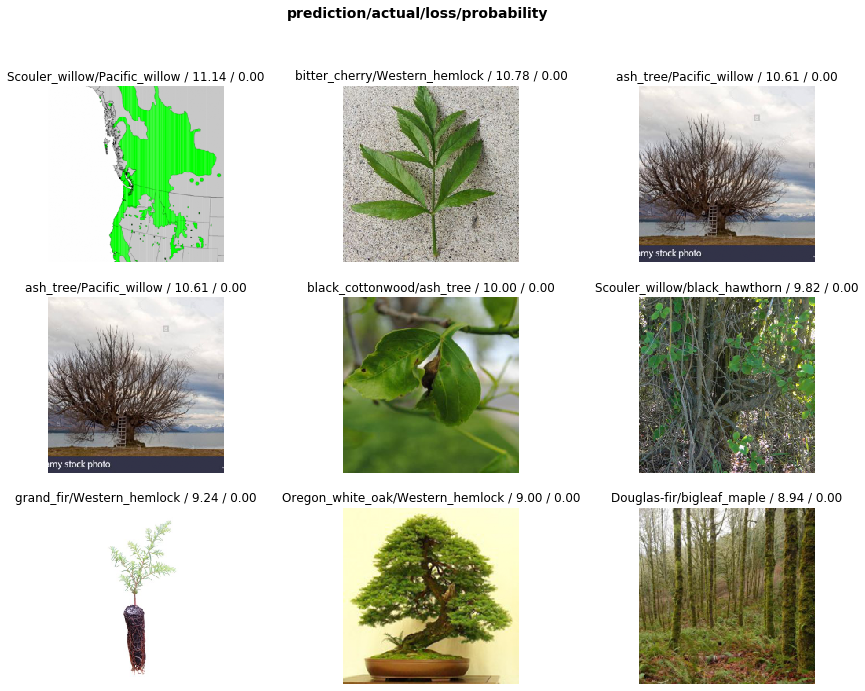

In [65]:
interp.plot_top_losses(9, figsize=(15,11))

# Load Best Model, and Export for Production

In [11]:
learn.load('bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (2924 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bigleaf_maple,bigleaf_maple,bigleaf_maple,bigleaf_maple,bigleaf_maple
Path: ../data/trees_and_leaves;

Valid: LabelList (730 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Scouler_willow,bitter_cherry,black_hawthorn,Pacific_yew,Pacific_willow
Path: ../data/trees_and_leaves;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1),

In [13]:
learn.export('exported.pkl')